final

In [ ]:
pip install esda

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import plotly.express as px
import geopandas as gpd
import esda
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import libpysal as lps
import os
import plotly.io as pio
import libpysal as lps
from libpysal.weights import DistanceBand
from libpysal.weights import KNN
from shapely.geometry import Point
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import cdist

# List of dataset files
crime_data = ["/content/drive/MyDrive/crime 10/ASSAULT_WITH_DEADLY_WEAPON,_AGGRAVATED_ASSAULT.csv",
                "/content/drive/MyDrive/crime 10/BATTERY_-_SIMPLE_ASSAULT.csv",
                "/content/drive/MyDrive/crime 10/BRANDISH_WEAPON.csv",
                "/content/drive/MyDrive/crime 10/BURGLARY.csv",
                "/content/drive/MyDrive/crime 10/BURGLARY_FROM_VEHICLE.csv",
                "/content/drive/MyDrive/crime 10/CRIMINAL_THREATS_-_NO_WEAPON_DISPLAYED.csv",
                "/content/drive/MyDrive/crime 10/INTIMATE_PARTNER_-_SIMPLE_ASSAULT.csv",
                "/content/drive/MyDrive/crime 10/ROBBERY.csv",
                "/content/drive/MyDrive/crime 10/SHOPLIFTING_-_PETTY_THEFT_($950_&_UNDER).csv",
                "/content/drive/MyDrive/crime 10/THEFT-GRAND_($950.01_&_OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD.csv",
                "/content/drive/MyDrive/crime 10/THEFT_FROM_MOTOR_VEHICLE_-_GRAND_($400_AND_OVER).csv",
                "/content/drive/MyDrive/crime 10/THEFT_FROM_MOTOR_VEHICLE_-_GRAND_($950.01_AND_OVER).csv",
                "/content/drive/MyDrive/crime 10/THEFT_FROM_MOTOR_VEHICLE_-_PETTY_($950_&_UNDER).csv",
                "/content/drive/MyDrive/crime 10/THEFT_OF_IDENTITY.csv",
                "/content/drive/MyDrive/crime 10/THEFT_PLAIN_-_PETTY_($950_&_UNDER).csv",
                "/content/drive/MyDrive/crime 10/TRESPASSING.csv",
                "/content/drive/MyDrive/crime 10/VANDALISM_-_FELONY_($400_&_OVER,_ALL_CHURCH_VANDALISMS).csv",
                "/content/drive/MyDrive/crime 10/VANDALISM_-_MISDEAMEANOR_($399_OR_UNDER).csv",
                "/content/drive/MyDrive/crime 10/VEHICLE_-_STOLEN.csv",
                "/content/drive/MyDrive/crime 10/VIOLATION_OF_RESTRAINING_ORDER.csv",
                "/content/drive/MyDrive/crime 10/remaining_crimes.csv"]

def determine_arima_order(time_series):
    # Perform ADF test
    result = adfuller(time_series)
    d = 0
    while result[1] > 0.05:
        time_series = time_series.diff().dropna()
        result = adfuller(time_series)
        d += 1

    # Plot ACF and PACF
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    sm.graphics.tsa.plot_acf(time_series, lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(time_series, lags=40, ax=ax[1])
    plt.show()

    # Determine p and q based on ACF and PACF
    p = np.argmax(np.abs(sm.tsa.acf(time_series, nlags=40)) < 2/np.sqrt(len(time_series)))
    q = np.argmax(np.abs(sm.tsa.pacf(time_series, nlags=40)) < 2/np.sqrt(len(time_series)))

  # Determine p and q based on ACF and PACF
    acf_values = sm.tsa.acf(time_series, nlags=40)
    pacf_values = sm.tsa.pacf(time_series, nlags=40)
    p = np.argmax(np.abs(pacf_values) < 2/np.sqrt(len(time_series)))
    q = np.argmax(np.abs(acf_values) < 2/np.sqrt(len(time_series)))

    return p, d, q

def process_dataset(file_path):
    # Extract file name without extension for the title
    file_name = os.path.splitext(os.path.basename(file_path))[0]

    # Load the dataset
    data1 = pd.read_csv(file_path)


    # Drop rows with missing LAT or LON
    data1.dropna(subset=['LAT', 'LON'], inplace=True)

    # Reset index
    data1.reset_index(drop=True, inplace=True)

    # Aggregate data by AREA and calculate mean of LAT, LON and count crimes
    agg_data = data1.groupby(['AREA']).agg({'LAT': 'mean', 'LON': 'mean', 'DATE OCC': 'count'}).reset_index()
    agg_data.rename(columns={'DATE OCC': 'Counts'}, inplace=True)

    # Ensure the Counts column is of type float
    agg_data['Counts'] = agg_data['Counts'].astype(float)

  # Convert to GeoDataFrame

    gdf = gpd.GeoDataFrame(agg_data, geometry=gpd.points_from_xy(agg_data.LON, agg_data.LAT))

    # Create spatial weights matrix
    w = lps.weights.KNN.from_dataframe(gdf, k=8)

    # Calculate Getis-Ord Gi* statistic
    gdf['Gi*'] = esda.getisord.G_Local(gdf['Counts'], w).Zs

    return gdf, file_name
    # Plot scatter plot with Gi* values
    fig = px.scatter_mapbox(gdf, lat='LAT', lon='LON', color='Gi*',
                            color_continuous_scale='Jet', hover_name="AREA",
                            size='Counts', size_max=15, zoom=10, mapbox_style="open-street-map")
    fig.update_layout(title_text=f'Crime Hotspots Scatter Plot by AREA with Gi* {file_name}')
    #fig.show()

    # Aggregate data by month and count crimes
    monthly_data = data1.groupby(['year', 'month']).size().reset_index(name='Counts')
    monthly_data['Date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))

    # Set Date as index
    monthly_data.set_index('Date', inplace=True)

     # Perform ADF test on the monthly data
    adf_result = adfuller(monthly_data['Counts'])
    print(f"ADF Statistic for {file_name}: {adf_result[0]}")
    print(f"p-value for {file_name}: {adf_result[1]}")
    print("Critical Values for ADF test:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.3f}")

    # Determine ARIMA order
    p, d, q = determine_arima_order(monthly_data['Counts'])
    print(f'Determined ARIMA order for {file_name}: (p={p}, d={d}, q={q})')

    # Fit ARIMA model
    arima_model = sm.tsa.ARIMA(monthly_data['Counts'], order=(p, d, q))
    arima_result = arima_model.fit()

    # Forecast with ARIMA
    arima_forecast = arima_result.get_forecast(steps=12)
    arima_forecast_df = arima_forecast.conf_int()
    arima_forecast_df['Forecast'] = arima_forecast.predicted_mean
    arima_forecast_df.index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]

    # Plot ARIMA forecast
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_data['Counts'], label='Observed')
    plt.plot(arima_forecast_df['Forecast'], label='ARIMA Forecast', color='red')
    plt.fill_between(arima_forecast_df.index, arima_forecast_df.iloc[:, 0], arima_forecast_df.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'ARIMA Forecast of Crime Counts for {file_name}')
    plt.legend()
    #plt.show()

    # Prepare data for Prophet
    prophet_data = monthly_data.reset_index()
    prophet_data.rename(columns={'Date': 'ds', 'Counts': 'y'}, inplace=True)

    # Fit Prophet model
    model = Prophet()
    model.fit(prophet_data)

    # Create future dataframe
    future = model.make_future_dataframe(periods=12, freq='M')
    forecast = model.predict(future)
    print("Prophet Forecast Values:")
    #print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

    # Plot Prophet forecast
    fig = model.plot(forecast)
    fig.suptitle(f'Prophet Forecast of Crime Counts for {file_name}')
    fig.tight_layout()
    #plt.show()

# Process each dataset
for file_path in crime_data:
    process_dataset(file_path)


Number of lags considered: 20
Sample size: 70


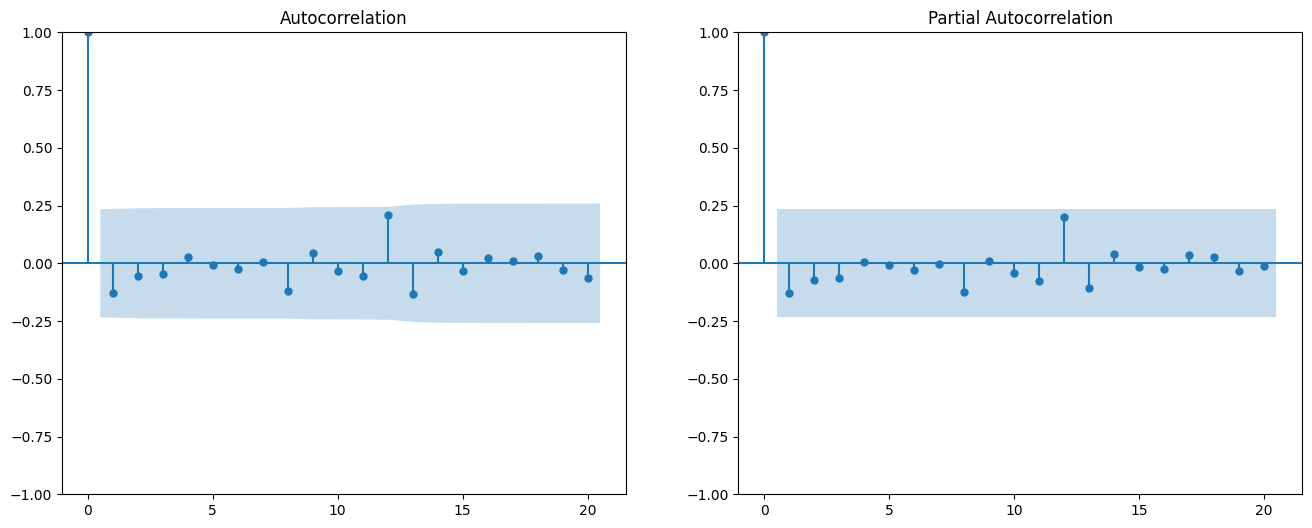

Determined ARIMA order for combined data: (p=1, d=1, q=1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



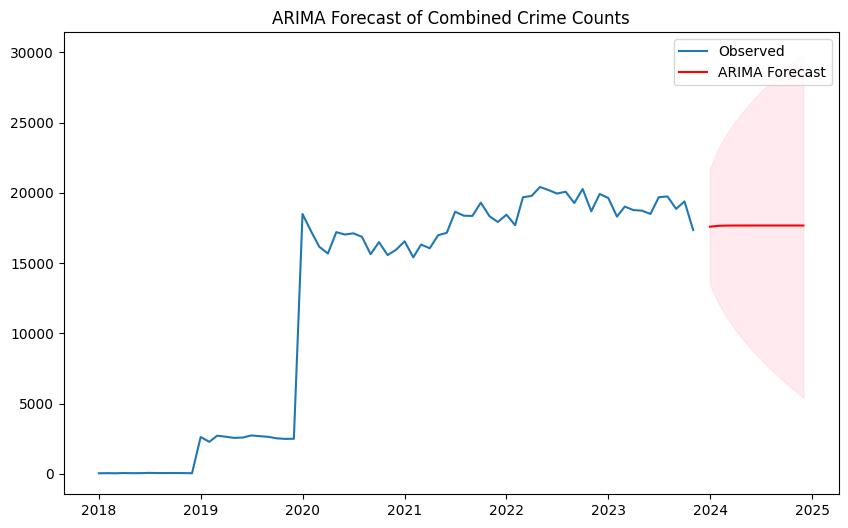

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplb7bvz5j/rmp6ver_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplb7bvz5j/entndqk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23338', 'data', 'file=/tmp/tmplb7bvz5j/rmp6ver_.json', 'init=/tmp/tmplb7bvz5j/entndqk2.json', 'output', 'file=/tmp/tmplb7bvz5j/prophet_modelcd5oc_xj/prophet_model-20240711195709.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:57:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Forecast Values:
           ds          yhat    yhat_lower    yhat_upper
71 2023-11-30  13850.960746  10392.857444  17097.313005
72 2023-12-31  36214.151224  33098.550476  39799.698745
73 2024-01-31  33444.286164  30072.139566  36677.158987
74 2024-02-29  21163.391465  17758.449360  24413.938132
75 2024-03-31  22643.385241  19227.390909  25923.440857
76 2024-04-30  23518.913805  19937.118832  26938.339856
77 2024-05-31  24680.685228  21656.923682  28116.659016
78 2024-06-30  25720.142000  22369.892138  29174.735479
79 2024-07-31  25470.372830  22054.051601  28990.733634
80 2024-08-31  24678.276286  21193.808271  28116.210473
81 2024-09-30  23318.363502  20022.290663  26585.519538
82 2024-10-31  20647.334444  17107.493931  23945.651859


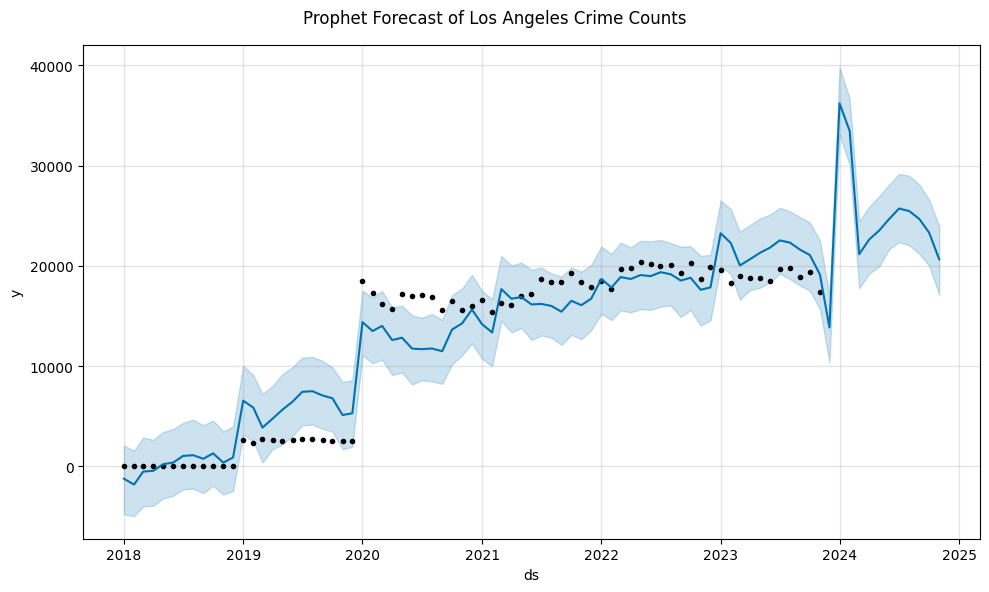

In [ ]:
def determine_arima_order(time_series, max_lags=20):
    # Ensure the series is not empty
    if len(time_series) <= 1:
        raise ValueError("Time series is too short to determine ARIMA order.")

    # Perform ADF test
    result = adfuller(time_series)
    d = 0
    while result[1] > 0.05 and d < 2:  # Limit to max 2 differences
        time_series = time_series.diff().dropna()
        result = adfuller(time_series)
        d += 1

    # Adjust max_lags based on the sample size
    nlags = min(max_lags, len(time_series) // 2 - 1)

    print(f"Number of lags considered: {nlags}")
    print(f"Sample size: {len(time_series)}")

    # Plot ACF and PACF
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    sm.graphics.tsa.plot_acf(time_series, lags=nlags, ax=ax[0])
    sm.graphics.tsa.plot_pacf(time_series, lags=nlags, ax=ax[1])
    plt.show()

    # Determine p and q based on ACF and PACF
    acf_values = sm.tsa.acf(time_series, nlags=nlags)
    pacf_values = sm.tsa.pacf(time_series, nlags=nlags)

    # Find p and q
    p = np.argmax(np.abs(pacf_values) < 2 / np.sqrt(len(time_series)))
    q = np.argmax(np.abs(acf_values) < 2 / np.sqrt(len(time_series)))

    return p, d, q

def combine_datasets(file_paths):
    combined_data = pd.DataFrame()
    for file_path in file_paths:
        data = pd.read_csv(file_path)
        combined_data = pd.concat([combined_data, data], ignore_index=True)
    return combined_data

# Combine the datasets
combined_data = combine_datasets(crime_data)
# Convert 'DATE OCC' to datetime if necessary
combined_data['DATE OCC'] = pd.to_datetime(combined_data['DATE OCC'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Extract additional time features if needed
combined_data['year'] = combined_data['DATE OCC'].dt.year
combined_data['month'] = combined_data['DATE OCC'].dt.month
combined_data['hour'] = combined_data['DATE OCC'].dt.hour

# Drop rows with missing LAT or LON
combined_data.dropna(subset=['LAT', 'LON'], inplace=True)

# Reset index
combined_data.reset_index(drop=True, inplace=True)
# Drop rows with missing LAT or LON
combined_data.dropna(subset=['LAT', 'LON'], inplace=True)

# Reset index
combined_data.reset_index(drop=True, inplace=True)

# Aggregate data by AREA and calculate mean of LAT, LON, and count crimes
agg_data = combined_data.groupby(['AREA']).agg({'LAT': 'mean', 'LON': 'mean', 'DATE OCC': 'count'}).reset_index()
agg_data.rename(columns={'DATE OCC': 'Counts'}, inplace=True)

# Ensure the Counts column is of type float
agg_data['Counts'] = agg_data['Counts'].astype(float)
# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(agg_data, geometry=gpd.points_from_xy(agg_data.LON, agg_data.LAT))
# Create spatial weights matrix
w = lps.weights.KNN.from_dataframe(gdf, k=8)

    # Calculate Getis-Ord Gi* statistic
gdf['Gi*'] = esda.getisord.G_Local(gdf['Counts'], w).Zs
# Plot scatter plot with Gi* values
fig = px.scatter_mapbox(gdf, lat='LAT', lon='LON', color='Gi*',
                        color_continuous_scale='Jet', hover_name="AREA",height=750,
                        size='Counts', size_max=15, zoom=10, mapbox_style="open-street-map")
fig.update_layout(title_text='Los Angeles Crime Hotspots Scatter Plot with Gi*',title_x=0.5)
fig.show()

# Save the hotspot plot as an HTML file
pio.write_html(fig, file='crime_hotspot_plot.html', auto_open=True)

# Aggregate data by month and count crimes
monthly_data = combined_data.groupby(['year', 'month']).size().reset_index(name='Counts')
monthly_data['Date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(DAY=1))

# Set Date as index
monthly_data.set_index('Date', inplace=True)

# Determine ARIMA order
p, d, q = determine_arima_order(monthly_data['Counts'])
print(f'Determined ARIMA order for combined data: (p={p}, d={d}, q={q})')

# Fit ARIMA model
arima_model = sm.tsa.ARIMA(monthly_data['Counts'], order=(p, d, q))
arima_result = arima_model.fit()

# Forecast with ARIMA
arima_forecast = arima_result.get_forecast(steps=12)
arima_forecast_df = arima_forecast.conf_int()
arima_forecast_df['Forecast'] = arima_forecast.predicted_mean
arima_forecast_df.index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]

# Plot ARIMA forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['Counts'], label='Observed')
plt.plot(arima_forecast_df['Forecast'], label='ARIMA Forecast', color='red')
plt.fill_between(arima_forecast_df.index, arima_forecast_df.iloc[:, 0], arima_forecast_df.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast of Combined Crime Counts')
plt.legend()
plt.show()

# Prepare data for Prophet
prophet_data = monthly_data.reset_index()
prophet_data.rename(columns={'Date': 'ds', 'Counts': 'y'}, inplace=True)

# Fit Prophet model
model = Prophet()
model.fit(prophet_data)

# Create future dataframe
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)
print("Prophet Forecast Values:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

# Plot Prophet forecast
fig = model.plot(forecast)
fig.suptitle('Prophet Forecast of Los Angeles Crime Counts')
fig.tight_layout()
plt.show()


In Prophet forecasting, the model sometimes limits the historical data shown in the forecast plot to maintain clarity and focus on the forecast period. Here are a few reasons why this might happen:

Default Plot Settings: Prophet's default plotting settings may truncate historical data to make the forecast period more prominent and to avoid cluttering the plot with excessive historical data.

Forecast Horizon: The plot is designed to highlight the forecasted future period, which can lead to a reduction in the amount of historical data displayed, especially if the forecast horizon is long relative to the historical data.

Data Density: If you have a large amount of historical data, displaying all of it on the plot might make it less readable. The plot might then automatically adjust the visible historical range to keep the forecast results clear and interpretable.

Plot Size: The size of the plot can also impact how much historical data is shown. If the plot area is constrained, it might limit the visible historical data to fit the plot space.

In [ ]:
# Perform ADF test on the monthly crime counts
# Print ADF test results
print("\nADF Test Results:")
print(f"ADF Statistic: {adf_result[0]:.3f}")
print(f"p-value: {adf_result[1]:.3f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.3f}")




ADF Test Results:
ADF Statistic: -1.535
p-value: 0.516
Critical Values:
   1%: -3.527
   5%: -2.904
   10%: -2.589


In [ ]:
start_date = '2018-01-01'
end_date = '2023-11-29'
observed = monthly_data.loc[start_date:end_date, 'Counts']
# Preparing Prophet data for RMSE calculation
prophet_forecast = forecast[['ds', 'yhat']].set_index('ds')
prophet_rmse = np.sqrt(mean_squared_error(observed, prophet_forecast.loc[start_date:end_date, 'yhat']))
print(f'Prophet RMSE: {prophet_rmse}')

Prophet RMSE: 2610.0479654902865
